In [260]:
import pandas as pd
import os
from matplotlib import pyplot as plt

DATA_DIR = 'data'

# Convert Excel to CSV

In [ ]:
# Convert xlsx files to csv files for 2017-2019 (makes it faster to load in the future)
# DONT RUN if csv files already exist

for year in range(2017, 2020):
    print(f"Converting {year}.xlsx to {year}.csv...")
    xlsx_path = os.path.join(DATA_DIR, f"{year}.xlsx")
    csv_path = os.path.join(DATA_DIR, f"{year}.csv")
    data = pd.read_excel(xlsx_path, header=1)
    data.to_csv(csv_path, index=False, encoding='euc-kr')

# Process and Load Data

In [ ]:
def clean_data(df: pd.DataFrame, includes_line: bool = False, includes_total: bool = False, includes_24: bool = True) -> pd.DataFrame:
    # TODO fix verification
    # Verify the structure of the old data
    # expected_columns = ['날짜', '역번호', '역명', '구분', '05~06', '06~07', '07~08',
    #    '08~09', '09~10', '10~11', '11~12', '12~13', '13~14',
    #    '14~15', '15~16', '16~17', '17~18', '18~19', '19~20',
    #    '20~21', '21~22', '22~23', '23~24', '24~']
    # if includes_line:
    #     expected_columns.insert(1, '호선')
    # if includes_total:
    #     expected_columns.append('합계')
    # assert list(df.columns.str.strip()) == expected_columns, "Data structure does not match expected format!"
    
    # Rename columns to English
    english_columns = ['Date', 'Station Number', 'Station Name', 'Boarding', '05~06', '06~07', '07~08',
    '08~09', '09~10', '10~11', '11~12', '12~13', '13~14',
    '14~15', '15~16', '16~17', '17~18', '18~19', '19~20',
    '20~21', '21~22', '22~23', '23~24']
    if includes_24:
        english_columns.append('24~')
    if includes_line:
        english_columns.insert(1, 'Line')
    if includes_total:
        english_columns.append('Total')
    df.columns = english_columns
    
    # Remove unnecessary column
    df.drop(columns=['Station Name'], inplace=True)

    # Ensure numeric columns are properly formatted
    col_start = 4 if includes_line else 3
    hours = 20 if includes_24 else 19
    col_end = col_start + hours
    for col in df.columns[col_start:col_end]:
        if df[col].dtype != 'int64':
            df[col] = df[col].astype(str)
            df[col] = pd.to_numeric(df[col].str.strip().str.replace(',', ''), errors='coerce').astype('Int64')
    if not includes_total:
        df["Total"] = df.iloc[:, col_start:col_end].sum(axis=1)

    # Convert Boarding to boolean
    df.Boarding = df.Boarding.apply(lambda x: True if "승차" in x else False)

    # Make sure line column is numeric if exists
    if includes_line and df.Line.dtype != 'int64':
        df.Line = df.Line.apply(lambda x: int(x[0]))
    
    # Convert Date to datetime
    df.Date = df.Date.str.strip()
    df.Date = pd.to_datetime(df.Date, format='mixed')
    df.set_index('Date', inplace=True)

    return df

In [ ]:
# Test
df = pd.read_csv(os.path.join(DATA_DIR, '2010.csv'), encoding='euc-kr')
clean_data(df)

,Station Number,Boarding,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,...,16~17,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,Total
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,150,True,390,400,452,1008,1326,1688,2265,2363,...,2794,2961,2463,2831,2070,2224,1716,804,18,35696
2010-01-01,150,False,187,1169,1171,1715,1984,2396,2209,2149,...,2015,1924,1898,1360,1147,1171,932,548,216,30956
2010-01-01,151,True,114,106,144,160,218,194,272,270,...,822,871,965,853,839,812,594,176,0,9068
2010-01-01,151,False,40,197,229,359,368,328,490,528,...,662,641,643,472,318,250,155,121,13,8134
2010-01-01,152,True,917,714,364,304,306,365,502,754,...,1851,2210,2243,2210,2090,2575,2583,1207,22,24934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31,2825,False,53,93,119,226,181,179,185,239,...,503,568,703,625,454,456,395,268,159,6536
2010-12-31,2826,True,127,186,594,762,421,234,234,330,...,341,393,388,263,205,184,161,67,36,5786
2010-12-31,2826,False,41,60,164,279,202,144,173,214,...,402,523,487,485,365,325,324,243,131,5600


In [ ]:
# Load data between 2008 and 2016
datasets = {}
for year in range(2008, 2017):
    print(f"Processing data for year: {year}...")
    file_path = os.path.join(DATA_DIR, f"{year}.csv")
    data = pd.read_csv(file_path, encoding='euc-kr')
    cleaned_data = clean_data_old(data)
    datasets[year] = cleaned_data
print("Done!")

Processing data for year: 2008...
Processing data for year: 2009...
Processing data for year: 2010...
Processing data for year: 2011...
Processing data for year: 2012...
Processing data for year: 2013...
Processing data for year: 2014...
Processing data for year: 2015...


/tmp/ipykernel_303513/4142177891.py:6: DtypeWarning: Columns (4,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding='euc-kr')


Processing data for year: 2016...
Done!


In [ ]:
# Load 2017
print("Processing data for year: 2017...")
df = pd.read_csv(os.path.join(DATA_DIR, '2017.csv'), encoding='euc-kr')
# Drop unnecessary columns
df.drop(columns=['구분'], inplace=True)

datasets[2017] = clean_data(df, includes_line=True, includes_total=True)

# Load 2018
print("Processing data for year: 2018...")
df = pd.read_csv(os.path.join(DATA_DIR, '2018.csv'), encoding='euc-kr')

datasets[2018] = clean_data(df, includes_line=True, includes_total=True)

# Load 2019
print("Processing data for year: 2019...")
df = pd.read_csv(os.path.join(DATA_DIR, '2019.csv'), encoding='euc-kr')

datasets[2019] = clean_data(df, includes_line=True, includes_total=True)

print("Done!")


Processing data for year: 2017...
Processing data for year: 2018...
Processing data for year: 2019...
Done!


In [ ]:
# Load 2020
print("Processing data for year: 2020...")
df = pd.read_csv(os.path.join(DATA_DIR, '2020.csv'), encoding='euc-kr')

datasets[2020] = clean_data(df, includes_line=True)

# Load 2021
print("Processing data for year: 2021...")
df = pd.read_csv(os.path.join(DATA_DIR, '2021.csv'), encoding='euc-kr')
df.drop(columns=['연번'], inplace=True)

datasets[2021] = clean_data(df, includes_line=True, includes_total=True, includes_24=False)

# Load 2022
print("Processing data for year: 2022...")
df = pd.read_csv(os.path.join(DATA_DIR, '2022.csv'), encoding='euc-kr')
df.drop(columns=['연번'], inplace=True)

datasets[2022] = clean_data(df, includes_line=True, includes_total=False)

# Load 2023
print("Processing data for year 2023...")
df = pd.read_csv(os.path.join(DATA_DIR, '2023.csv'), encoding='euc-kr')
df.drop(columns=['연번'], inplace=True)

datasets[2023] = clean_data(df, includes_line=True)

# Load 2024
print("Processing data for year: 2024...")
df = pd.read_csv(os.path.join(DATA_DIR, '2024.csv'), encoding='euc-kr')
df.drop(columns=['연번'], inplace=True)

datasets[2024] = clean_data(df, includes_line=True)

print("All data processing complete!")

Processing data for year: 2020...
Processing data for year: 2021...
Processing data for year: 2022...


/tmp/ipykernel_303513/3004505707.py:16: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2022.csv', encoding='euc-kr')


Processing data for year 2023...
Processing data for year: 2024...
All data processing complete!


In [239]:
# Merge all datasets into a single DataFrame
all_data = pd.concat(datasets.values())
all_data

,Station Number,Boarding,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,...,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,Total,Line
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,150,True,379,287,371,876,965,1389,1989,2375,...,3495,3055,2952,2726,3307,2584,1059,264,38765,NaN
2008-01-01,150,False,145,707,689,1037,1170,1376,1451,1743,...,2203,2128,1747,1593,1078,744,406,558,26950,NaN
2008-01-01,151,True,131,131,101,152,191,202,275,361,...,1154,1706,1444,1267,928,531,233,974,12591,NaN
2008-01-01,151,False,35,158,203,393,375,460,591,841,...,1303,1190,830,454,284,141,107,185,12089,NaN
2008-01-01,152,True,1287,867,400,330,345,338,595,791,...,2777,2834,2646,2784,2920,2290,802,1559,29071,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,2826,False,14,85,152,477,233,191,191,250,...,465,468,376,261,248,246,175,68,5260,8.0
2024-12-31,2827,True,80,103,332,400,241,241,268,336,...,440,381,247,136,170,140,90,50,5236,8.0
2024-12-31,2827,False,19,109,138,428,219,197,234,266,...,340,374,281,193,212,207,141,128,4589,8.0


# Data Exploration

In [240]:
# Check missing values
all_data.isnull().sum()

Station Number          0
Boarding                0
05~06                   0
06~07                   0
07~08                   0
08~09                   0
09~10                   0
10~11                   0
11~12                   0
12~13                   0
13~14                   0
14~15                   0
15~16                   0
16~17                   0
17~18                   0
18~19                   0
19~20                   0
20~21                   0
21~22                   0
22~23                   0
23~24                   0
24~                286720
Total                   0
Line              1771882
dtype: int64

The data is surprisingly clean. The NaNs in line appear because there were many years where line was not included. It may be possible to calculate line values by looking at the number of people getting on and off but that would require a lot of work and line numbers are not required for out goal. Additionally, there are some datasets where no data was supplied for `24~` so just setting those to 0 would probably be the best option.

In [241]:
# Basic statistics
all_data.describe().apply(lambda s: s.apply('{0:.0f}'.format))


,05~06,06~07,07~08,08~09,09~10,10~11,11~12,12~13,13~14,14~15,...,17~18,18~19,19~20,20~21,21~22,22~23,23~24,24~,Total,Line
count,3378600,3378600,3378600,3378600,3378600,3378600,3378600,3378600,3378600,3378600,...,3378600,3378600,3378600,3378600,3378600,3378600,3378600,3091880,3378600,1606718
mean,133,378,985,1682,1073,734,709,753,818,811,...,1164,1606,1193,815,760,684,377,105,16521,5
std,197,404,1283,2341,1368,717,671,701,784,780,...,1178,1912,1387,944,938,903,505,185,15001,2
min,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25%,31,129,228,397,351,290,289,318,339,335,...,461,525,366,265,241,198,95,8,6953,3
50%,66,247,508,925,657,522,509,546,580,566,...,802,997,733,507,467,409,220,43,11994,5
75%,160,469,1206,1927,1213,876,870,922,998,991,...,1388,1837,1449,971,878,800,458,130,20552,6
max,13826,11083,15305,30554,19971,18902,14667,25062,22378,20476,...,25070,21362,23451,21403,37273,24125,17470,37569,153559,8


In [244]:
# Total number of passengers boarded/alighted from 2008 to 2024
# Make sure to only rows with  boarded
total_passengers = all_data[all_data['Boarding'] == True]['Total'].sum()
print(f"total_passengers: {total_passengers}")

total_passengers: 27853438004


Date
2008    1653790554
2009    1656231259
2010    1680484820
2011    1712346466
2012    1724410138
2013    1754129534
2014    1780433495
2015    1748429998
2016    1744517114
2017    1744350934
2018    1751566339
2019    1769057411
2020    1282084664
2021    1291481383
2022    1416734071
2023    1547141920
2024    1596247904
dtype: int64

<Axes: title={'center': 'Total Passengers Per Year'}, xlabel='Year', ylabel='Number of Passengers'>

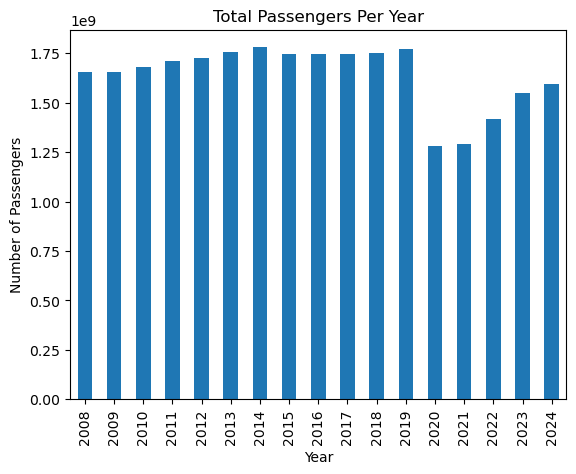

In [248]:
# Get total number of passengers per year
passengers_per_year = all_data.groupby(all_data.index.year).apply(lambda x: x[x['Boarding'] == True]['Total'].sum())
display(passengers_per_year)
passengers_per_year.plot(kind='bar', title='Total Passengers Per Year', xlabel='Year', ylabel='Number of Passengers')

Date  Date
2008  1       137539388
      2       120471048
      3       145461537
      4       141626930
      5       144343297
                ...    
2024  8       127178579
      9       123278873
      10      138301989
      11      138558904
      12      139181088
Length: 204, dtype: int64

<Axes: title={'center': 'Total Passengers Per Month'}, xlabel='Year-Month', ylabel='Number of Passengers'>

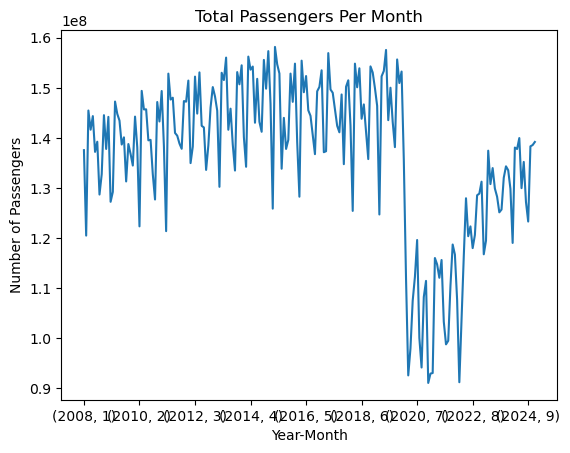

In [252]:
# Get total number of passengers per month
passengers_per_month = all_data.groupby([all_data.index.year, all_data.index.month]).apply(lambda x: x[x['Boarding'] == True]['Total'].sum())
display(passengers_per_month)
passengers_per_month.plot(title='Total Passengers Per Month', xlabel='Year-Month', ylabel='Number of Passengers')

Date
1     1.327336e+08
2     1.218879e+08
3     1.424647e+08
4     1.402500e+08
5     1.430516e+08
6     1.355123e+08
7     1.373617e+08
8     1.305904e+08
9     1.301277e+08
10    1.408761e+08
11    1.409918e+08
12    1.425898e+08
dtype: float64

<Axes: title={'center': 'Average Passengers Per Month'}, xlabel='Month', ylabel='Number of Passengers'>

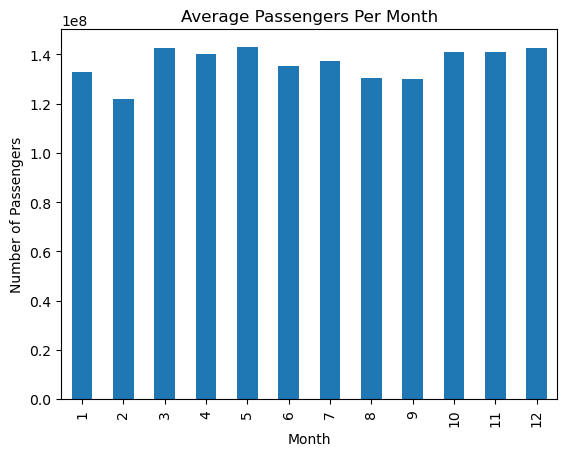

In [253]:
# Get average number of passengers per month over all years
average_passengers_per_month = all_data.groupby(all_data.index.month).apply(lambda x: x[x['Boarding'] == True]['Total'].sum() / x.index.year.nunique())
display(average_passengers_per_month)
average_passengers_per_month.plot(kind='bar', title='Average Passengers Per Month', xlabel='Month', ylabel='Number of Passengers')

Date
0    2.093200e+07
1    2.153237e+07
2    2.158632e+07
3    2.169916e+07
4    2.229268e+07
5    1.672388e+07
6    1.177005e+07
dtype: float64

<Axes: title={'center': 'Average Passengers Per Day of Week'}, xlabel='Day of Week (0=Monday)', ylabel='Number of Passengers'>

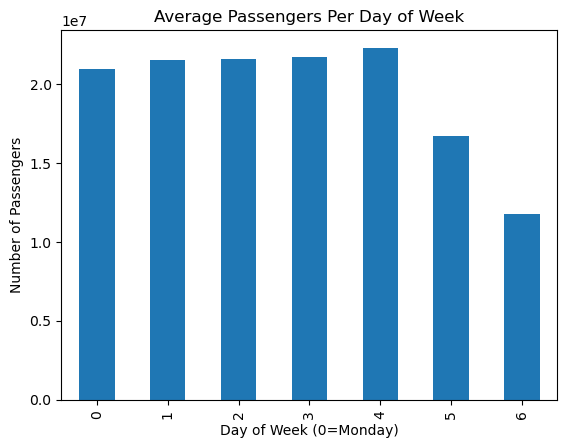

In [254]:
# Get average number of passengers per day of week
average_passengers_per_dayofweek = all_data.groupby(all_data.index.dayofweek).apply(lambda x: x[x['Boarding'] == True]['Total'].sum() / x.index.year.nunique() / x.index.month.nunique())
display(average_passengers_per_dayofweek)
average_passengers_per_dayofweek.plot(kind='bar', title='Average Passengers Per Day of Week', xlabel='Day of Week (0=Monday)', ylabel='Number of Passengers')

/tmp/ipykernel_303513/3458109817.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_passengers_per_station_month = all_data.groupby([all_data.index.year, all_data.index.month, 'Station Number']).apply(lambda x: x['Total'].sum())


Date  Date  Station Number
2008  1     150               3275396
            151               1678273
            152               3525073
            153               2665552
            154               1616395
                               ...   
2024  12    2824               709422
            2825               325400
            2826               334439
            2827               298985
            2828               452369
Length: 56188, dtype: int64

/tmp/ipykernel_303513/3458109817.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
/tmp/ipykernel_303513/3458109817.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
/tmp/ipykernel_303513/3458109817.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
/tmp/ipykernel_303513/3458109817.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
/tmp/ipykernel_303513/3458109817.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals =

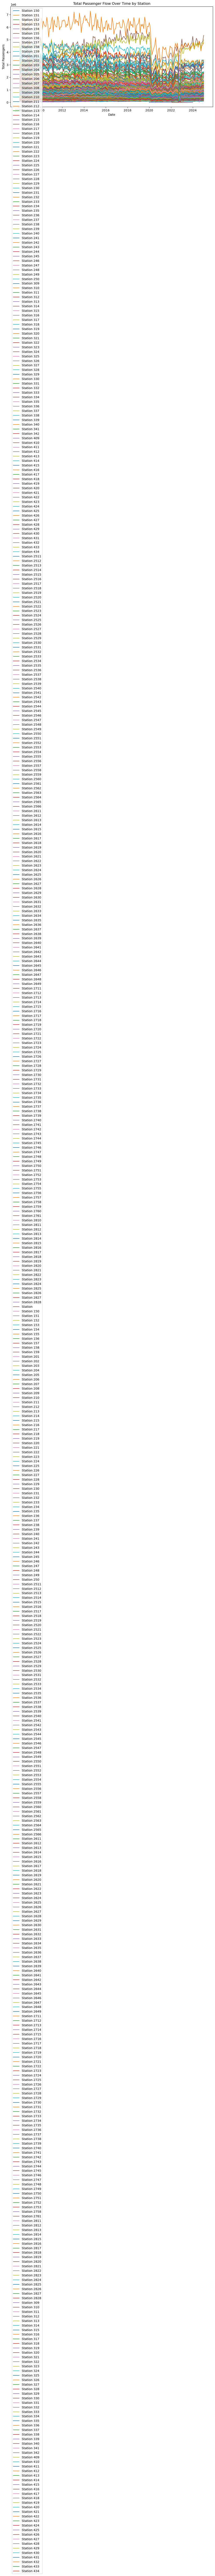

In [267]:
# Get total passenger flow (both boarding and alighting) per station per month
total_passengers_per_station_month = all_data.groupby([all_data.index.year, all_data.index.month, 'Station Number']).apply(lambda x: x['Total'].sum())
display(total_passengers_per_station_month)

# Plot total passenger flow for all stations over time in a single plot
plt.figure(figsize=(12, 6))
for station_number, group in all_data.groupby('Station Number'):
    monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
    plt.plot(monthly_totals.index, monthly_totals.values, label=f'Station {station_number}')
plt.title('Total Passenger Flow Over Time by Station')
plt.xlabel('Date')
plt.ylabel('Total Passengers')
plt.legend()
plt.show()

/tmp/ipykernel_303513/38898043.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_stations = all_data.groupby('Station Number').apply(lambda x: x['Total'].sum()).nlargest(10).index
/tmp/ipykernel_303513/38898043.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
/tmp/ipykernel_303513/38898043.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
/tmp/ipykernel_303513/38898043.py:5: FutureWarning: 'M' is deprecated and will be removed in a future v

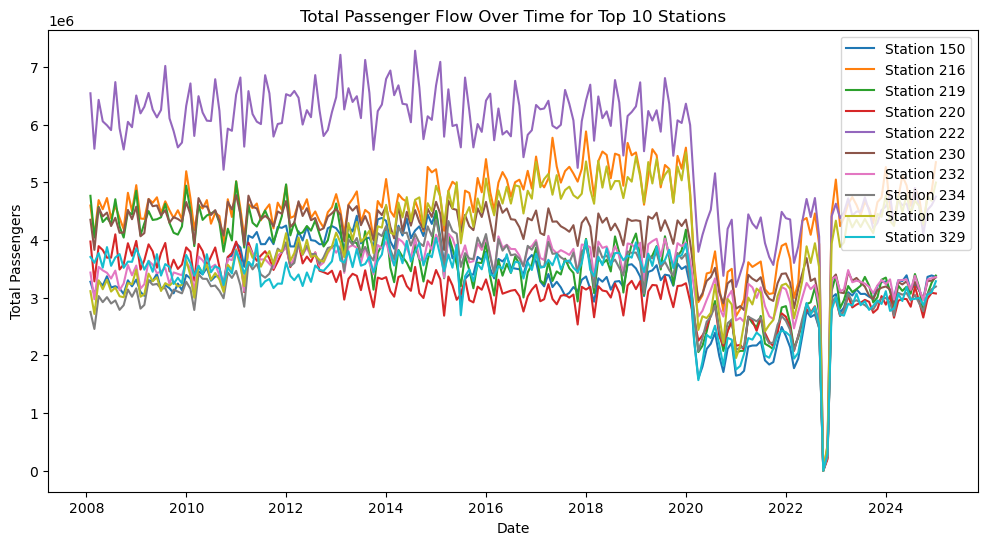

In [269]:
# Make a similar plot but only for top 10 stations with highest total passengers
top_10_stations = all_data.groupby('Station Number').apply(lambda x: x['Total'].sum()).nlargest(10).index
plt.figure(figsize=(12, 6))
for station_number, group in all_data[all_data['Station Number'].isin(top_10_stations)].groupby('Station Number'):
    monthly_totals = group.resample('M').apply(lambda x: x['Total'].sum())
    plt.plot(monthly_totals.index, monthly_totals.values, label=f'Station {station_number}')
plt.title('Total Passenger Flow Over Time for Top 10 Stations')
plt.xlabel('Date')
plt.ylabel('Total Passengers')
plt.legend()
plt.show()